In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# dataset load
data = pd.read_csv("/home/dataset/complete.csv")
# data_only_pm25 = pd.DataFrame(data.loc[:, ["PM-2.5", "일시"]])
data["일시"] = pd.to_datetime(data["일시"])
data.index = data["일시"]
del data["일시"]
data = data.iloc[50:, :]
data.head()

,평균기온(°C),최저기온(°C),최고기온(°C),강수 계속시간(hr),일강수량(mm),평균 풍속(m/s),최다풍향(16방위),최소 상대습도(%),평균 상대습도(%),평균 현지기압(hPa),...,일 최심적설(cm),평균 전운량(1/10),평균 지면온도(°C),최저 초상온도(°C),PM-10,PM-2.5,o3,no2,co,so2
일시,,,,,,,,,,,,,,,,,,,,,
2018-04-01,15.6,11.7,18.5,0.00,0.0,1.5,200.0,50.0,68.8,1006.3,...,0.0,9.1,14.3,6.2,57.0,27.0,0.028,0.039,0.5,0.004
2018-04-02,18.4,14.9,23.7,0.00,0.0,1.9,230.0,41.0,64.0,1005.4,...,0.0,6.1,17.8,11.1,58.0,21.0,0.028,0.039,0.5,0.005
2018-04-03,17.8,14.9,21.2,2.92,0.1,2.1,230.0,50.0,72.9,1006.4,...,0.0,9.1,17.2,13.8,61.0,16.0,0.018,0.042,0.5,0.005
2018-04-04,13.4,9.5,18.2,6.50,18.5,1.9,90.0,40.0,67.0,1007.4,...,0.0,6.1,15.9,7.9,9.0,4.0,0.024,0.031,0.4,0.003
2018-04-05,7.6,6.7,9.5,19.67,10.5,2.0,90.0,61.0,90.6,1005.7,...,0.0,9.9,8.9,6.2,5.0,3.0,0.015,0.039,0.5,0.003


In [4]:
data.columns.get_loc("PM-2.5")

17

In [4]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, forecast_size:int):
    self.lookback_size = lookback_size
    self.forecast_size = forecast_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.forecast_size + 1

  def __getitem__(self, i):
    idx = (i+self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[idx:idx+self.forecast_size]

    return look_back, forecast

In [5]:
from sklearn.preprocessing import MinMaxScaler
m_data = data.copy()
m_data = m_data.dropna()

tst_size=200

lookback_size = 9
forecast_size = 4

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(m_data[:-tst_size].to_numpy(dtype=np.float32))
tst_scaled = scaler.transform(m_data[-tst_size-lookback_size:].to_numpy(dtype=np.float32))

trn_ds = TimeSeriesDataset(trn_scaled, lookback_size, forecast_size)
tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [8]:
x, y = next(iter(trn_dl))
x.shape, y.shape
32,4

(torch.Size([32, 9, 22]), torch.Size([32, 4, 22]))

In [9]:
class NetMulti(nn.Module):
  def __init__(self, d_in, d_out, d_hidden, c_in, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in*c_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_out)
    self.activation = activation

  def forward(self, x):
    x = x.flatten(1)    # (B, d_in * c_in)
    x = self.lin1(x)    # (B, d_hidden)
    x = self.activation(x)
    x = self.lin2(x)    # (B, d_out)
    return F.sigmoid(x)

In [20]:
from tqdm.auto import trange
c_in = 22
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = NetMulti(9, 4, 512, c_in)
net.to(device)

optim = torch.optim.AdamW(net.parameters(), lr=0.0001)

pbar = trange(100)
for i in pbar:
  net.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.flatten(1).to(device), y[:,:,17].to(device)   # (32, 18), (32, 4)
    p = net(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(trn_ds)

  net.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.flatten(1).to(device), y[:,:,17].to(device)
    p = net(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

In [22]:
net.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.flatten(1).to(device), y[:,:,17].to(device)
  p = net(x)

y = y.cpu()/scaler.scale_[0] + scaler.min_[0]
p = p.cpu()/scaler.scale_[0] + scaler.min_[0]

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])


In [19]:
y.shape

(200,)

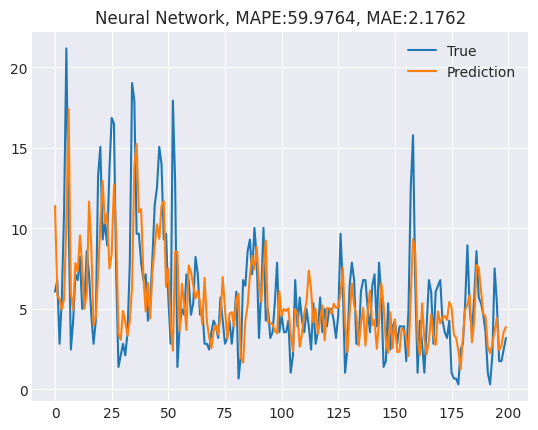

NameError: name 'res_dict' is not defined

In [23]:

plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9*2, 512, 4)': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})